<a href="https://colab.research.google.com/github/jear2412/MCMC/blob/master/PTHMCcaseB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

sns.set()

#PTHMC Case B

In [7]:
def ClassMatrix(x, means):
    temp = np.zeros( shape=(x.shape[0], means.shape[0]) )
    #q = 9.21034 / 100
    for i in range( x.shape[0]):
        temp2=np.zeros( means.shape[0] )
        for j in range( means.shape[0] ):
            temp2[j] =np.dot( x[i] - means[j], x[i] - means[j] )
        index_min = np.argmin(temp2 )
        temp[i][index_min]=1
    return temp

#estimation of weights
def weights(x, means, size):
    #take a sample of size=size and calculate the weights
    indexes = np.random.choice( np.arange( 0, len(x) ), size=size, replace=False )
    temp=ClassMatrix(x[indexes], means)
    return np.mean(temp, 0)


def AFER( fw, tw):
    '''Average frecuency error rate 
    fw: frequency weight
    tw: true weight 
    Calculate \sum| fw-tw | '''
    return np.sum( np.abs(  fw-tw ) )


def fpoints(f, args, theta,  pars , lb, upb, m=100):
    '''f is the objective function to be plotted
       args are the arguments of f as a list
       theta is the vector of true parameters
       pars are the parameters to be plotted (passed as an array)
       lb: array of lower bounds
       upb: array of upper bounds
       '''
       
    xx = np.linspace(lb[0], upb[0], m)
    yy = np.linspace(lb[1], upb[1], m)
    xx, yy = np.meshgrid(xx, yy)
    Z = np.zeros(shape=[m, m])

    for i in range( m ):
        for j in range( m ):
            temp=np.array( [xx[i][j], yy[i][j]] )
            Z[i][j] = f( temp )
    return xx,yy,Z 

def pContour(xx,yy,Z,c=100):
    plt.contour( xx, yy, Z, c, colors='b' )
    plt.xlabel( r'$\theta_1$' )
    plt.ylabel( r'$\theta_2$' )
    plt.title( r'Objective Function Contours' )
    plt.show()    

# log target f(x) case b

def logf(x):
    if(x[0]>0 and x[0]>0 and x[0]<10 and x[1]<10   ):
      w = 1/np.sqrt(np.sum(np.square((mu-[5,5])),1))
      v = np.sqrt(np.sum(np.square((mu-[5,5])),1))/20
      return np.log(np.sum((w/v)*np.exp(-1.0/(2.0*v)*np.sum(np.square(x-mu),1))))
    else:
      return -np.inf 

def Analysis(x):
    var=np.var(x,0)

    ess=np.zeros( x.shape[1])
    for i in range( x.shape[1] ):
      ess[i]=tfp.mcmc.effective_sample_size(  x[:,i] , filter_beyond_positive_pairs=True)
    
    mess=np.min(ess)
    N=x.shape[0]
    summary= {
        "TotalObs": N,
        "Variance": var,
        "mVar": var/ess,
        "ess": ess,
        "mess":mess, #min ess
        "IAT": N/ess, 
        }
    return summary      



In [8]:
mu = np.array(
    [[2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82], [3.25, 3.47], [1.70, 0.50], [4.59, 5.60],
     [6.91, 5.81], [6.87, 5.40], [5.41, 2.65], [2.70, 7.88], [4.98, 3.70], [1.14, 2.39], [8.33, 9.50], [4.93, 1.5],
     [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]] )

num_mixtures = 20 #number of mixture components
dim = 2  # mixture of bivariate Gaussians

real_weights=np.zeros(20)
for i in range(20):
  real_weights[i]=1/(  np.sqrt( np.dot(mu[i]-np.array([5,5]),mu[i]-np.array([5,5]))    )   )


real_weights=real_weights/np.sum(real_weights)
print(real_weights)



[0.04579808 0.02276038 0.03755132 0.02810495 0.0337176  0.05754243
 0.02396969 0.18406182 0.06447266 0.06994638 0.05607158 0.03629122
 0.10287907 0.02870615 0.02389351 0.03820911 0.02288663 0.02462541
 0.06906161 0.02945039]


In [10]:
CBdE=pd.read_csv('CBdE.csv')
CBdex=pd.read_csv('CBdex.csv')
CBdms=pd.read_csv('CBAdms.csv')
CBobs=pd.read_csv('CBobs.csv')


In [11]:
pd.DataFrame.describe(CBobs)


,Unnamed: 0,theta1,theta2,E,lp__
count,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000
mean,135000.500000,4.665906,5.071948,0.994319,-0.994319
std,77942.430678,1.818357,2.397006,1.523303,1.523303
min,1.000000,-0.499358,-1.939294,-1.796264,-11.053548
25%,67500.750000,3.677301,3.483737,-0.103628,-1.991548
50%,135000.500000,4.706088,5.526517,1.067779,-1.067779
75%,202500.250000,5.556498,6.309581,1.991548,0.103628
max,270000.000000,10.782102,11.510385,11.053548,1.796264


In [12]:
pd.DataFrame.median(CBobs)


Unnamed: 0    135000.500000
theta1             4.706088
theta2             5.526517
E                  1.067779
lp__              -1.067779
dtype: float64

In [13]:
pd.DataFrame.quantile(CBobs, (0.025, 0.975))

,Unnamed: 0,theta1,theta2,E,lp__
0.025,6750.975,1.149618,0.081356,-1.684324,-4.053309
0.975,263250.025,8.515031,9.378262,4.053309,1.684324


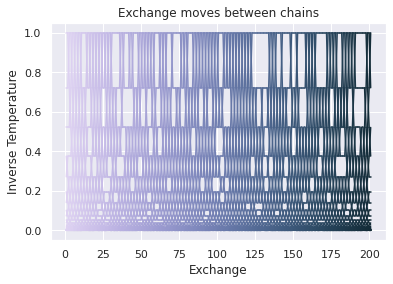

In [14]:
ax=sns.lineplot(x="x", y="y", hue="g",data=CBdex, legend=False,  palette="ch:2.5,.25") 
ax.set(xlabel="Exchange", ylabel = "Inverse Temperature")
ax.set_title('Exchange moves between chains')
plt.savefig('PTCB1.png', dpi=500)

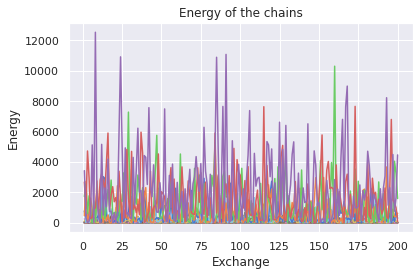

In [15]:
ax=sns.lineplot(x="Exchange", y="E", hue="Replica", data=CBdE, legend=False,  palette="muted")
ax.set(xlabel="Exchange", ylabel = "Energy")
ax.set_title('Energy of the chains')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig('PTCB2.png', dpi=450)

In [16]:
x1= CBobs['theta1']
x2= CBobs['theta2']

In [19]:
results=CBobs[[ 'theta1','theta2']]
results=pd.DataFrame.to_numpy(results) 
analysis=Analysis( results)
analysis

{'IAT': array([ 978.93541917, 2029.43715674]),
 'TotalObs': 270000,
 'Variance': array([3.3064086 , 5.74561772]),
 'ess': array([275.80981821, 133.04181364]),
 'mVar': array([0.011988  , 0.04318656]),
 'mess': 133.04181363969468}

In [20]:
size=analysis['TotalObs']
ws_t=weights( results, means= mu, size= size )
print('Average AFER: ', AFER(ws_t, real_weights ))
print('Average # of Modes Discovered: ', np.sum(ws_t>0))

Average AFER:  0.11906860482841772
Average # of Modes Discovered:  20


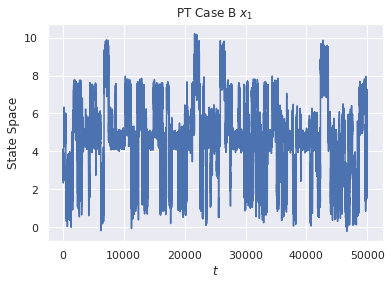

In [22]:
sns.set()
plt.plot(results[0:50000,0])
plt.xlabel( r'$t$' )
plt.ylabel( 'State Space' )
plt.title( r'PT Case B '+r'$x_1$'  )
plt.savefig('traceplot-PTBx1.png', dpi=500)    
plt.show()

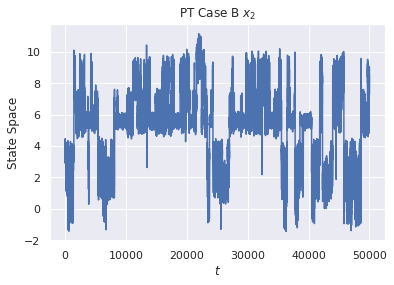

In [23]:
sns.set()
plt.plot(results[0:50000,1])
plt.xlabel( r'$t$' )
plt.ylabel( 'State Space' )
plt.title( r'PT Case B '+r'$x_2$'  )
plt.savefig('traceplot-PTBx2.png', dpi=500)    
plt.show()

In [24]:

xx,yy,Z= fpoints(f= logf ,args=(0,), theta=(), pars=(),
                  lb= np.array([0,0]), upb= np.array([10, 10]) , m=200 ) #takes time :)

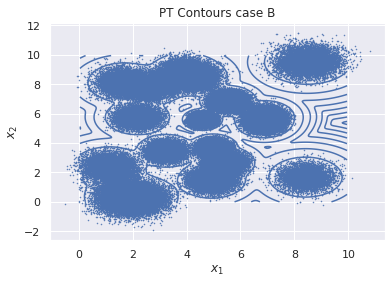

In [26]:
sns.set()
plt.contour( xx, yy, -Z, 10, colors='b' )
plt.scatter( results[:, 0 ], results[:, 1 ], s=0.25 )
plt.xlabel( r'$x_1$' )
plt.ylabel( r'$x_2$' )
plt.title( r'PT Contours case B' )
plt.savefig('PTContoursB.png', dpi=500)    
plt.show()

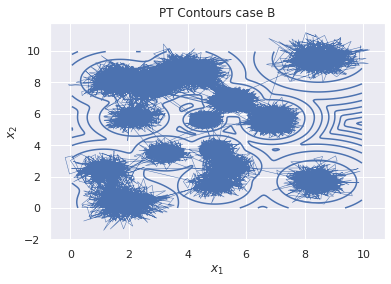

In [51]:
sns.set()
plt.contour( xx, yy, -Z, 10, colors='b' )
plt.plot( results[0:25000, 0 ], results[0:25000, 1 ], linewidth=0.3 )
plt.xlabel( r'$x_1$' )
plt.ylabel( r'$x_2$' )
plt.title( r'PT Contours case B' )
plt.savefig('PTContoursBtrace4.png', dpi=500)    
plt.show()